In [1]:
import matplotlib.pylab as plt
# import networkx as nx
import numpy as np
import pandas as pd
import time
import sys
import os
import textwrap

In [2]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Case, When, Value as V
from django.db import models

/home/finn/anaconda3/envs/textmining/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
tm.RunStats.objects.filter(psearch__title__startswith="Kohle", method='NM', K=30)


<QuerySet [<RunStats: RunStats object (44)>, <RunStats: RunStats object (43)>]>

In [35]:
K=30
method = 'NM'
search_word = "Energie"
run_id1 = tm.RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K).run_id
run_id2 = tm.RunStats.objects.get(psearch__title="{} pdf utterance".format(search_word), method=method, K=K).run_id
print(run_id1)
print(run_id2)

stat1 = tm.RunStats.objects.get(pk=run_id1)
topics1 = tm.Topic.objects.filter(run_id=stat1.parent_run_id)

stat2 = tm.RunStats.objects.get(pk=run_id2)
topics2 = tm.Topic.objects.filter(run_id=stat2.parent_run_id)

DoesNotExist: RunStats matching query does not exist.

In [14]:
print(topics2)

<QuerySet [<Topic: {bundeswehr, soldat, wehrbeauftragt}>, <Topic: {sag, herr, ganz}>, <Topic: {ausschuss, abgeordnet, drucksach}>, <Topic: {erneuerbar, energi, eeg}>, <Topic: {million, euro, mittel}>, <Topic: {prozent, klimaschutz, ziel}>, <Topic: {unternehm, mittelstand, deutschland}>, <Topic: {russland, staat, polit}>, <Topic: {landwirtschaft, landlich, raum}>, <Topic: {beschlussempfehl, drucksach, stimmt}>, <Topic: {gesetz, gesetzentwurf, regel}>, <Topic: {nachhalt, entwickl, nachhaltigkeitsstrategi}>, <Topic: {wald, holz, waldbesitz}>, <Topic: {kernenergi, kernkraftwerk, ausstieg}>, <Topic: {kind, famili, jugend}>, <Topic: {stadt, stadtebauforder, programm}>, <Topic: {energiew, altmai, energieeffizienz}>, <Topic: {kommun, land, bund}>, <Topic: {meer, schutz, maritim}>, <Topic: {entwicklungspolit, entwicklungsland, afrika}>, '...(remaining elements truncated)...']>


In [36]:
for i in topics1.values('id', 'top_words'):
    print("{}: {}".format(i['id'], i['top_words']))

1170: ['haushalt', 'milliard', 'jahr', 'bundeshaushalt', 'ausgab', 'bund', 'schuld', 'koalition', 'finanzpolit', 'eichel']
1169: ['klimaschutz', 'paris', 'klimawandel', 'ziel', 'deutschland', 'klimaschutzplan', 'gabriel', 'hendrick', 'mehr', 'frau']
1168: ['million', 'haushalt', 'mittel', 'einzelplan', 'euro', 'programm', 'minist', 'bereich', 'forder', 'jahr']
1167: ['forschung', 'bildung', 'innovation', 'hochschul', 'wissenschaft', 'bulmahn', 'entwickl', 'neu', 'eigenheimzulag', 'forschungspolit']
1166: ['ccs', 'technologi', 'ccstechnologi', 'speicher', 'abscheid', 'kohl', 'wirkungsgrad', 'gesetzentwurf', 'ccsgesetz', 'erprob']
1165: ['bergrecht', 'fracking', 'rohstoff', 'bergbau', 'erdgas', 'forderabgab', 'bodenschatz', 'deutschland', 'bundesberggesetz', 'interess']
1164: ['okosteu', 'okolog', 'umweltpolit', 'steuerreform', 'steu', 'rotgrun', 'belast', 'grun', 'oko', 'pfennig']
1163: ['prozent', 'jahr', 'deutschland', 'anteil', 'ziel', 'erreich', 'tonn', 'pro', 'gas', 'zahl']
1162: [

In [37]:
% matplotlib inline

# topic proportions according to party
# copied from parliament/views -> adapted for utterance
run_id = run_id1

colors = []
party_scores = []
party_names = []
norm_scores = []
topic_ids = []
topic_list = []
total_scores = []

for topic in tm.Topic.objects.filter(run_id=run_id).order_by('score'):
    # print(topic)
    s = tm.RunStats.objects.get(run_id=run_id).psearch
    party_totals = pm.Utterance.objects.filter(
        search_matches=s,
        doctopic__topic__run_id=run_id,
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=topic, then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )
        ),
        total_score=Sum('doctopic__score'),
    ).annotate(
        topic_proportion=F('topic_score') / F('total_score')
    ).values(
        'topic_proportion',
        'speaker__party__id',
        'speaker__party__name',
        'speaker__party__colour'
    )

    colors.append([d['speaker__party__colour'] for d in party_totals])
    party_names.append([d['speaker__party__name'] for d in party_totals])
    sc = [d['topic_proportion'] for d in party_totals]
    party_scores.append(sc)
    norm_scores.append(np.array(sc) / sum(sc))
    topic_ids.append(topic.id)
    topic_list.append(topic.top_words)
    total_scores.append(topic.score)

In [24]:
print(party_scores)
#print(party_names)
print(topic_ids)
np.array(party_scores).sum(0)

[[0.0151331306970961, 0.0126673292808894, 0.0092700424741855, 0.0204722286752467, 0.0204790255112472], [0.0187371554648064, 0.0263403876450921, 0.0130826787638533, 0.0178112011323259, 0.0202339683372387], [0.0196560613569538, 0.0171776882398372, 0.0159900332383757, 0.0398036787582985, 0.0171447218031411], [0.0132245936206007, 0.0304632752976277, 0.0216692702586028, 0.0174558430111053, 0.023213901824919], [0.0192176152195454, 0.0116161762009868, 0.0325110440228055, 0.0320516065734788, 0.0239367611179917], [0.0166662000798569, 0.0151343723612379, 0.0333493685407825, 0.0449059573324883, 0.0226962707900011], [0.026550188121241, 0.0171526943043273, 0.0202837380812098, 0.0210133574993599, 0.0301619813332093], [0.0253586660623712, 0.0293503893676044, 0.0263997859358447, 0.030925282642251, 0.0229952479365518], [0.0207075385350205, 0.0429825828659383, 0.02866002696095, 0.0318021159938453, 0.0226406529169492], [0.0196691372414953, 0.0230934405855413, 0.0355446127242435, 0.0444718812494621, 0.024

array([1., 1., 1., 1., 1.])

In [25]:
# similarly for regions of speakers
# -> this implementation is not working but should be faster, when debugged

'''
region_scores = []
topic_ids2 = []

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])

topics = tm.Topic.objects.filter(run_id=run_id).order_by('score')[0:2]

arrays = [range(len(topics)),
          ['direct', 'list', 'sum']]

index = pd.MultiIndex.from_product(arrays, names=['topic #', 'seat_type'])
df_regions = pd.DataFrame(index=index, columns=['coal', 'ncoal', 'top_words'])

index_to_keyword = {0: 'coal', 1: 'ncoal'}
for i, topic in enumerate(topics):
    #print(topic.top_words)
    
    region_scores_collect = []
    
    for j, regions in enumerate([coal_regions, non_coal_regions]):
        #print(list(regions))

        # differentiate between different seat types (list or direct mandate):
        # list: speaker -> seat -> partylist -> region
        ut_list = pm.Utterance.objects.filter(search_matches=s,
                            doctopic__topic__run_id=run_id,
                            speaker__seat__seat_type=2).distinct()
        ut_list = ut_list.filter(speaker__seat__list__region__in=regions)

        # direct: speaker -> seat -> consituency -> region
        ut_direct = pm.Utterance.objects.filter(search_matches=s,
                            doctopic__topic__run_id=run_id,
                            speaker__seat__seat_type=1).distinct()
        ut_direct = ut_direct.filter(speaker__seat__constituency__region__in=regions)
        ut = ut_list.union(ut_direct)

        region_score = ut.order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            ).values('topic_proportion')

        print(region_score)
        region_scores_collect.append(region_score)
    
    region_scores.append(region_scores_collect)
    topic_ids2.append(topic.id)
'''

'\nregion_scores = []\ntopic_ids2 = []\n\ncoal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])\nnon_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",\n                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",\n                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])\n\ntopics = tm.Topic.objects.filter(run_id=run_id).order_by(\'score\')[0:2]\n\narrays = [range(len(topics)),\n          [\'direct\', \'list\', \'sum\']]\n\nindex = pd.MultiIndex.from_product(arrays, names=[\'topic #\', \'seat_type\'])\ndf_regions = pd.DataFrame(index=index, columns=[\'coal\', \'ncoal\', \'top_words\'])\n\nindex_to_keyword = {0: \'coal\', 1: \'ncoal\'}\nfor i, topic in enumerate(topics):\n    #print(topic.top_words)\n    \n    region_scores_collect = []\n    \n    for j, regions in enumerate([coal_regions, non_coal_regions]):\n  

In [38]:
# this implementation is working but really slow
# because it makes queries to the database for every topic and region separately

recalc = True

if recalc:

coal_regions = cmodels.Region.objects.filter(name__in=["Brandenburg", "North Rhine-Westphalia", "Saxony"])
non_coal_regions = cmodels.Region.objects.filter(name__in=["Baden-Württemberg", "Bavaria", "Berlin", "Bremen", "Hamburg", "Hesse",
                    "Mecklenburg-Vorpommern", "Lower Saxony", "Rheinland-Pfalz",
                    "Saarland", "Saxony-Anhalt", "Schleswig-Holstein", "Thuringia"])

topics = tm.Topic.objects.filter(run_id=run_id).order_by('score')
seat_types = ['direct', 'list', 'sum']
arrays = [range(len(topics)), seat_types]

index = pd.MultiIndex.from_product(arrays, names=['topic #', 'seat_type'])
df_regions = pd.DataFrame(index=index, columns=['coal', 'ncoal', 'topic_id', 'top_words'])

index_to_keyword = {0: 'coal', 1: 'ncoal'}


for i, topic in enumerate(topics):
    print(topic.top_words)

    for j, regions in enumerate([coal_regions, non_coal_regions]):
        print(list(regions))

        region_score_list = pm.Utterance.objects.filter(
                search_matches=s,
                doctopic__topic__run_id=run_id,
                speaker__seat__seat_type=2,
                speaker__seat__list__region__in=regions
            ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            )#.values('topic_proportion')

        region_score_direct = pm.Utterance.objects.filter(
                search_matches=s,
                doctopic__topic__run_id=run_id,
                speaker__seat__seat_type=1,
                speaker__seat__constituency__region__in=regions
            ).distinct().order_by().values('speaker__seat__seat_type').annotate(
                topic_score=models.Sum(
                    models.Case(
                        models.When(doctopic__topic=topic, then=models.F('doctopic__score')),
                        default=0,
                        output_field=models.FloatField()
                    )
                ),
                total_score=models.Sum('doctopic__score'),
            ).annotate(
                topic_proportion=models.F('topic_score') / models.F('total_score')
            )#.values('topic_proportion')
        
        for st in seat_types:
            df_regions['top_words'][(i, st)] = topic.top_words
            df_regions['topic_id'][(i, st)] = topic.id

        df_regions[index_to_keyword[j]][(i, 'direct')] = region_score_direct[0]['topic_proportion']
        df_regions[index_to_keyword[j]][(i, 'list')] = region_score_list[0]['topic_proportion']
        total_score = region_score_list[0]['topic_proportion'] + region_score_direct[0]['topic_proportion'] / 2.
        df_regions[index_to_keyword[j]][(i, 'sum')] = total_score
        
        print("score list: {}".format(region_score_list[0]['topic_proportion']))
        print("score direct: {}".format(region_score_direct[0]['topic_proportion']))
        print("sum: {}".format(total_score))
        

['michael', 'thomas', 'pet', 'wolfgang', 'christian', 'andreas', 'johann', 'matthias', 'norbert', 'klaus']
[<Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.0269071189687675
score direct: 0.00770921007078339
sum: 0.030761724004159195
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saxony-Anhalt>, <Region: Saarland>, <Region: Rheinland-Pfalz>, <Region: Lower Saxony>, <Region: Mecklenburg-Vorpommern>, <Region: Hesse>, <Region: Hamburg>, <Region: Bremen>, <Region: Berlin>, <Region: Bavaria>, <Region: Baden-Württemberg>]
score list: 0.0202703418858117
score direct: 0.0172054032517413
sum: 0.02887304351168235
['miet', 'energet', 'vermiet', 'wohnung', 'sanier', 'mietrecht', 'sozial', 'mieterinn', 'stadt', 'wohn']
[<Region: Saxony>, <Region: North Rhine-Westphalia>, <Region: Brandenburg>]
score list: 0.011151346727143
score direct: 0.0172186532208378
sum: 0.0197606733375619
[<Region: Thuringia>, <Region: Schleswig-Holstein>, <Region: Saxony

In [39]:
if recalc:
    regions_data_filename = "regions_scores_{}_{}_K{}_run_id{}.csv".format(search_word, method, K, run_id)
    df_regions.to_csv(regions_data_filename)

    if os.path.isfile(regions_data_filename):
        df_regions_test = pd.read_csv(regions_data_filename, index_col=[0,1], skipinitialspace=True)
    df_regions_test

coal     ncoal  topic_id  \
topic # seat_type                                 
0       direct     0.007709  0.017205      4895   
        list       0.026907  0.020270      4895   
        sum        0.030762  0.028873      4895   
1       direct     0.017219  0.017408      4894   
        list       0.011151  0.016670      4894   
        sum        0.019761  0.025374      4894   
2       direct     0.023089  0.023406      4899   
        list       0.017626  0.017430      4899   
        sum        0.029170  0.029133      4899   
3       direct     0.039472  0.016851      4888   
        list       0.022992  0.025791      4888   
        sum        0.042728  0.034216      4888   
4       direct     0.017496  0.032317      4887   
        list       0.064436  0.032493      4887   
        sum        0.073184  0.048652      4887   
5       direct     0.018441  0.028068      4879   
        list       0.038667  0.029198      4879   
        sum        0.047887  0.043232      4879   
6       direct     0.018591  0.026160      4883   
        list       0.020358  0.025086      4883   
        sum        0.029654  0.038166      4883   
7       direct     0.026620  0.029182      4897   
        list       0.020520  0.028685      4897   
        sum        0.033830  0.043276      4897   
8       direct     0.019647  0.036109      4875   
        list       0.042911  0.042331      4875   
        sum        0.052735  0.060386      4875   
9       direct     0.025514  0.025821      4890   
        list       0.018545  0.022572      4890   
        sum        0.031302  0.035483      4890   
...                     ...       ...       ...   
20      direct     0.031449  0.029400      4886   
        list       0.041296  0.039865      4886   
        sum        0.057020  0.054565      4886   
21      direct     0.034178  0.042260      4889   
        list       0.025621  0.031683      4889   
        sum        0.042710  0.052812      4889   
22      direct     0.052497  0.031021      4874   
        list       0.037309  0.037244      4874   
        sum        0.063558  0.052754      4874   
23      direct     0.040078  0.043479      4878   
        list       0.030219  0.037879      4878   
        sum        0.050258  0.059619      4878   
24      direct     0.044489  0.055885      4873   
        list       0.033765  0.036071      4873   
        sum        0.056009  0.064013      4873   
25      direct     0.046222  0.038379      4892   
        list       0.047268  0.041259      4892   
        sum        0.070379  0.060448      4892   
26      direct     0.048240  0.045934      4876   
        list       0.034522  0.037390      4876   
        sum        0.058641  0.060356      4876   
27      direct     0.038809  0.056527      4884   
        list       0.036005  0.044796      4884   
        sum        0.055410  0.073060      4884   
28      direct     0.059020  0.058779      4871   
        list       0.050812  0.066888      4871   
        sum        0.080322  0.096278      4871   
29      direct     0.082731  0.071576      4880   
        list       0.050016  0.056452      4880   
        sum        0.091382  0.092240      4880   

                                                           top_words  
topic # seat_type                                                     
0       direct     ['michael', 'thomas', 'pet', 'wolfgang', 'chri...  
        list       ['michael', 'thomas', 'pet', 'wolfgang', 'chri...  
        sum        ['michael', 'thomas', 'pet', 'wolfgang', 'chri...  
1       direct     ['miet', 'energet', 'vermiet', 'wohnung', 'san...  
        list       ['miet', 'energet', 'vermiet', 'wohnung', 'san...  
        sum        ['miet', 'energet', 'vermiet', 'wohnung', 'san...  
2       direct     ['kommun', 'stadt', 'kommunal', 'gemeind', 'bu...  
        list       ['kommun', 'stadt', 'kommunal', 'gemeind', 'bu...  
        sum        ['kommun', 'stadt', 'kommunal', 'gemeind', 'bu...  
3       direct     ['umweltp

In [33]:
if not recalc:
    regions_data_filename = "regions_scores_{}_{}_K{}_run_id{}.csv".format(search_word, method, K, run_id)
    df_regions = pd.read_csv(regions_data_filename, index_col=[0,1], skipinitialspace=True)

In [41]:
idx = pd.IndexSlice
region_data = df_regions.loc[idx[:,'sum'],['coal','ncoal']].values
normalized_region_data = np.array([i / sum(i) for i in region_data])

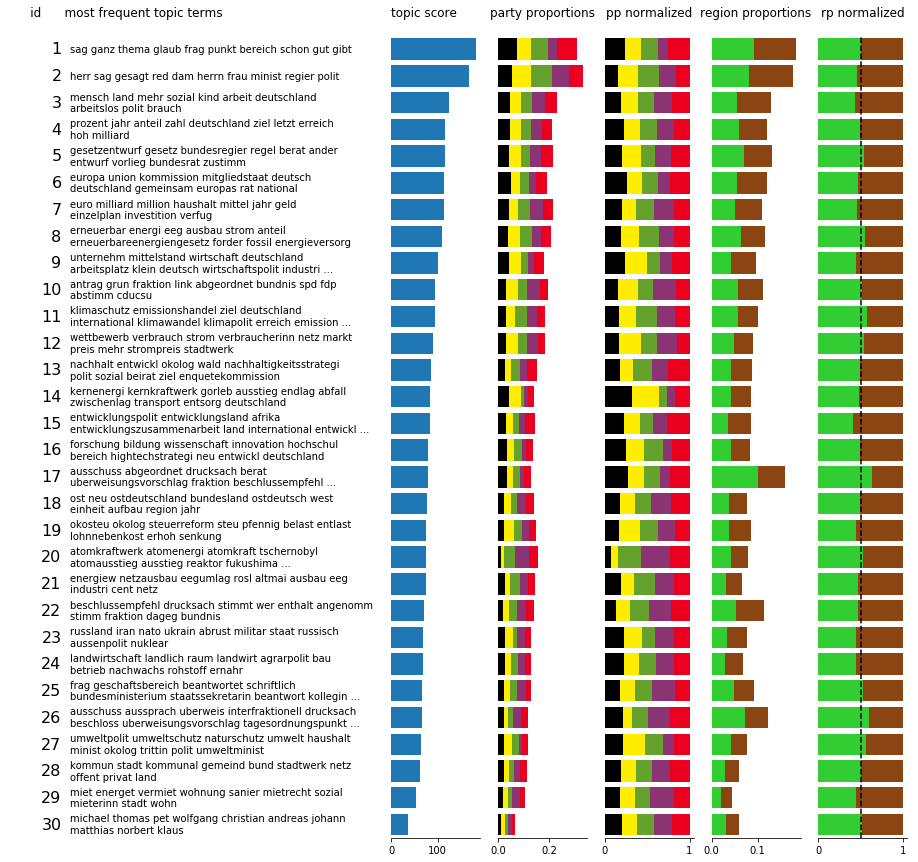

In [42]:
# plot list of topics and visualize scores for parties and regions

k = len(topic_ids)

# indices of topics to plot
#index_list = [0,3,7,8,9,10,12,13, 14, 15, 16, 18, 22, 24]
index_list = range(k)
plotted_topics = len(index_list)
y_pos = np.arange(plotted_topics)
fig, axs = plt.subplots(1, 8, figsize=(15,plotted_topics/2), sharey=True)

# topic description
ax = axs[0]
# numbering from 1 to ...
description_list = np.arange(k, 0, -1)
# indices
#description_list = np.arange(0, k)
# topic id in database
#description_list = np.array(topic_id)


box_props = dict(boxstyle='round', fc="w", ec="k")
indexed_topic_list = np.array(topic_list)[index_list]
for i, text in enumerate(description_list[index_list]):
    ax.text(-0.1, y_pos[i], text,
            horizontalalignment='right',
            verticalalignment='center',
           fontsize=16)
    topic_text = textwrap.fill(" ".join(indexed_topic_list[i]), width=55)
    if len(topic_text.split("\n")) > 2:
        topic_text = "\n".join(topic_text.split("\n")[0:2]) + " ..."
    text_element = ax.text(0, y_pos[i], topic_text, fontsize=10,
        verticalalignment='center', horizontalalignment='left')

ax.set_axis_off()
ax.set_title("      id      most frequent topic terms", loc='center')

ax = axs[1]
ax.set_axis_off()
ax = axs[2]
ax.set_axis_off()

# total scores
ax = axs[3]
patch_handles = []
ax.barh(y_pos, np.array(total_scores)[index_list], align='center')
ax.set_title("topic score", loc='left')

# party proportions
ax = axs[4]
data = np.array(party_scores)[index_list].T
plot_colors = np.array(colors)[index_list].T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center', 
      left=left))
    # accumulate the left-hand offsets
    left += d
ax.set_title("party proportions")


# normalized party scores
ax = axs[5]
data = np.array(norm_scores)[index_list].T
plot_colors = np.array(colors)[index_list].T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center',
      left=left))
    # accumulate the left-hand offsets
    left += d
ax.set_title("pp normalized")

# region scores
ax = axs[6]
data = np.array(region_data)[index_list].T
plot_colors = np.tile(['limegreen', 'saddlebrown'], (plotted_topics,1)).T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center',
      left=left))
    # accumulate the left-hand offsets
    left = left + d
ax.set_title("region proportions")

# normalized region scores
ax = axs[7]
data = np.array(normalized_region_data)[index_list].T
plot_colors = np.tile(['limegreen', 'saddlebrown'], (plotted_topics,1)).T
patch_handles = []
left = np.zeros(plotted_topics) # left alignment of data starts at zero
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
      color=plot_colors[i], align='center',
      left=left))
    # accumulate the left-hand offsets
    left = left + d
ax.plot([0.5, 0.5], [-0.5, plotted_topics-0.5], 'k--')
ax.set_title("rp normalized")

for ax in axs[3:8]:
    ax.yaxis.set_visible(False) # Hide only x axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

ax.set_ylim(-0.5, plotted_topics)

fig.savefig("topic_list_{}_{}_K{}_run_id{}.png".format(search_word, method, K, run_id), 
            bbox_inches='tight', dpi=150)

In [ ]:
region_data.sum(0)

In [ ]:
region_data

In [ ]:
plot_colors

In [ ]:
# todo: make more efficient by requesting all data at once
party_totals = pm.Utterance.objects.filter(
    search_matches=s,
    doctopic__topic__run_id=stat,
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic, then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )
    ),
    total_score=Sum('doctopic__score'),
).annotate(
    topic_proportion=F('topic_score') / F('total_score')
).values(
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
)